In [1]:
import os
os.chdir('../..')
!ls

product_impacts


In [32]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
import statistics
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../SFS/NDNS UK/ndns_edited.csv')
products = get_products()
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../SFS/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6460
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Non-Alcoholic Beverages'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Non-Alcoholic Beverages')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(25994, 11)

In [12]:
lab.shape

(7087, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Tea (made up)                                         1944
Coffee (made up weight)                               1032
Soft drinks not low calorie carbonated                 854
Bottled water still or carbonated                      694
Fruit juice                                            535
Soft drinks low calorie carbonated                     470
Smoothies                                              370
Soft drinks not low calorie, ready to drink, still     326
Soft drinks not low calorie concentrated               317
Soft drinks low calorie concentrated                   251
Soft drinks low calorie, ready to drink, still         232
Herbal tea (made up)                                    62
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Tea, coffee and water    3732
Soft drinks, not diet    1497
Soft drinks, diet         953
Fruit juice               905
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Tea (made up)                                                 1943
Coffee (made up weight)                                       1030
Soft drinks not low calorie carbonated                         854
Bottled water still or carbonated                              694
Fruit juice                                                    535
Soft drinks low calorie carbonated                             470
Smoothies                                                      370
Soft drinks not low calorie, ready to drink, still             326
Soft drinks not low calorie concentrated                       317
Soft drinks low calorie concentrated                           251
Soft drinks low calorie, ready to drink, still                 232
Beverages dry weight                                           119
Low alcohol & alcohol free beer & lager                         71
Herbal tea (made up)                                            62
Low alcohol and alcohol free wine                             

In [16]:
# correcting some labels

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('peppermint')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('ginger'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea'))
        & (~lab['product_list_name'].str.lower().str.contains('black tea'))
        & (~lab['product_list_name'].str.lower().str.contains('charitea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('rooibos')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('magnesium')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('mint infusion')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('immune support')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('chamomile')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('vitality')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('turmeric'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('yogi'))
        & (~lab['product_list_name'].str.lower().str.contains('matcha')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('fruit'))
        & (~lab['product_list_name'].str.lower().str.contains('green'))
        & (~lab['product_list_name'].str.lower().str.contains('black tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('boutique'))
        & (~lab['product_list_name'].str.lower().str.contains('diet')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('herbal')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('feel new')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('sleep')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('redbush')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('camomile')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('detox'))
        & (~lab['product_list_name'].str.lower().str.contains('green')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('cold infuse')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('echinacea'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('cherry'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('blueberry'))
        & (~lab['product_list_name'].str.lower().str.contains('white tea'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('cleanse'))
        & (~lab['product_list_name'].str.lower().str.contains('vitamin'))
        & (~lab['product_list_name'].str.lower().str.contains('teapigs')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('acai')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('aduna')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('fennel'))
        & (~lab['product_list_name'].str.lower().str.contains('white tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('lychee'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea'))
        & (~lab['product_list_name'].str.lower().str.contains('souffle')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('cold infusions')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('apple'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea'))
        & (~lab['product_list_name'].str.lower().str.contains('chai'))
        & (~lab['product_list_name'].str.lower().str.contains('grn'))
        & (~lab['product_list_name'].str.lower().str.contains('black tea'))
        & (~lab['product_list_name'].str.lower().str.contains('iced tea')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('peach'))
        & (~lab['product_list_name'].str.lower().str.contains('green tea'))
        & (~lab['product_list_name'].str.lower().str.contains('black tea'))
        & (~lab['product_list_name'].str.lower().str.contains('iced tea'))
        & (~lab['product_list_name'].str.lower().str.contains('ice tea'))
        & (~lab['product_list_name'].str.lower().str.contains('fuze'))
        & (~lab['product_list_name'].str.lower().str.contains('lift'))
        & (~lab['product_list_name'].str.lower().str.contains('lipton'))
        & (~lab['product_list_name'].str.lower().str.contains('may tea'))
        & (~lab['product_list_name'].str.lower().str.contains('zero'))
        & (~lab['product_list_name'].str.lower().str.contains('white tea'))
        & (~lab['product_list_name'].str.lower().str.contains('sparkling')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('blood orange')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('herb garden')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('morrocan mint')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'

lab.loc[(lab['subfoodgroupdesc']=='Tea (made up)')
        & (lab['product_list_name'].str.lower().str.contains('chakra')),
        'subfoodgroupdesc'] = 'Herbal tea (made up)'


lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['product_list_name'].str.lower().str.contains('sparkling'))
        & (lab['ingredients_text'].str.lower().str.contains('citric')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['ingredients_text'].str.lower().str.contains('sugar'))
        & (lab['ingredients_text'].str.lower().str.contains('sparkling')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['product_list_name'].str.lower().str.contains('soda'))
        & (lab['ingredients_text'].str.lower().str.contains('citric')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['ingredients_text'].str.lower().str.contains('juice'))
        & ((lab['ingredients_text'].str.lower().str.contains('sparkling'))
          | (lab['ingredients_text'].str.lower().str.contains('carbonated'))),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & ((lab['ingredients_text'].str.lower().str.contains('flavour'))
          | (lab['product_list_name'].str.lower().str.contains('apple')))
        & ((lab['ingredients_text'].str.lower().str.contains('sparkling'))
          | (lab['ingredients_text'].str.lower().str.contains('carbonated'))),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['product_list_name'].str.lower().str.contains('soda')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (~lab['product_list_name'].str.lower().str.contains('sparkling'))
        & (~lab['product_list_name'].str.lower().str.contains('soda'))
        & (~lab['product_list_name'].str.lower().str.contains('squash'))
        & (~lab['product_list_name'].str.lower().str.contains('tonic'))
        & (lab['ingredients_text'].str.lower().str.contains('citric')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['ingredients_text'].str.lower().str.contains('sugar'))
        & (~lab['ingredients_text'].str.lower().str.contains('sparkling')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['ingredients_text'].str.lower().str.contains('juice'))
        & (~lab['ingredients_text'].str.lower().str.contains('sparkling'))
        & (~lab['ingredients_text'].str.lower().str.contains('carbonated')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & ((lab['ingredients_text'].str.lower().str.contains('flavour'))
          | (lab['product_list_name'].str.lower().str.contains('apple')))
        & (~lab['ingredients_text'].str.lower().str.contains('sparkling'))
        & (~lab['ingredients_text'].str.lower().str.contains('carbonated')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['product_list_name'].str.lower().str.contains('orange squash')),
        'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'

lab.loc[(lab['subfoodgroupdesc']=='Bottled water still or carbonated')
        & (lab['product_list_name'].str.lower().str.contains('tonic'))
        & (lab['ingredients_text'].str.lower().str.contains('citric')),
        'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'


lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('coconut')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('sugar'))
        & (~lab['ingredients_text'].str.lower().str.contains('carbonated')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('squash'))
        & (~lab['product_list_name'].str.lower().str.contains('sugar')),
        'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('squash'))
        & (lab['product_list_name'].str.lower().str.contains('sugar')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie concentrated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('sugar'))
        & (lab['ingredients_text'].str.lower().str.contains('carbonated')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('tonic')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['ingredients_text'].str.lower().str.contains('carbonated')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['ingredients_text'].str.lower().str.contains('100')),
        'subfoodgroupdesc'] = 'Fruit juice'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('100')),
        'subfoodgroupdesc'] = 'Fruit juice'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('apple juice')),
        'subfoodgroupdesc'] = 'Fruit juice'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie, ready to drink, still')
        & (lab['product_list_name'].str.lower().str.contains('innocent')),
        'subfoodgroupdesc'] = 'Smoothies'


lab.loc[(lab['subfoodgroupdesc']=='Soft drinks low calorie, ready to drink, still')
        & (lab['ingredients_text'].str.lower().str.contains('carbonated'))
        & (~lab['ingredients_text'].str.lower().str.contains('beet sugar'))
        & ((lab['ingredients_text'].str.lower().str.contains('sugar'))
          | (lab['ingredients_text'].str.lower().str.contains('glucose'))),
        'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks low calorie, ready to drink, still')
        & (lab['ingredients_text'].str.lower().str.contains('carbonated'))
        & (lab['ingredients_text'].str.lower().str.contains('beet sugar')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lab.loc[(lab['subfoodgroupdesc']=='Soft drinks low calorie, ready to drink, still')
        & (lab['ingredients_text'].str.lower().str.contains('carbonated'))
        & (~lab['ingredients_text'].str.lower().str.contains('sugar'))
        & (~lab['ingredients_text'].str.lower().str.contains('glucose')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'


lab.loc[(lab['subfoodgroupdesc']=='Soft drinks not low calorie concentrated')
        & (lab['product_list_name'].str.lower().str.contains('fizzy')),
        'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

In [17]:
# correcting the lev 1 categories and codes
lab = lab.drop(['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode'], axis=1)
lab = lab.merge(
    ndns[['mainfoodgroupcode', 'mainfoodgroupdesc', 'subfoodgroupcode', 'subfoodgroupdesc']].drop_duplicates(
        subset=['subfoodgroupdesc']), how='left')

In [18]:
lab['subfoodgroupdesc'].value_counts()

Tea (made up)                                         1377
Coffee (made up weight)                               1032
Soft drinks not low calorie carbonated                 908
Soft drinks low calorie carbonated                     676
Herbal tea (made up)                                   629
Fruit juice                                            550
Soft drinks low calorie, ready to drink, still         413
Bottled water still or carbonated                      375
Smoothies                                              372
Soft drinks not low calorie concentrated               320
Soft drinks low calorie concentrated                   251
Soft drinks not low calorie, ready to drink, still     184
Name: subfoodgroupdesc, dtype: int64

In [19]:
lab['mainfoodgroupdesc'].value_counts()

Tea, coffee and water    3413
Soft drinks, not diet    1412
Soft drinks, diet        1340
Fruit juice               922
Name: mainfoodgroupdesc, dtype: int64

In [20]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Non-Alcoholic Beverages'
lev2_labels_add['subfoodgroupdesc'] = np.NaN


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("matcha"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("nespresso")),
                    'subfoodgroupdesc'] = 'Tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vitamin tea")),
                    'subfoodgroupdesc'] = 'Tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lipton peach")),
                    'subfoodgroupdesc'] = 'Tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("green tea ginger")),
                    'subfoodgroupdesc'] = 'Tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("turmeric infusion tea")),
                    'subfoodgroupdesc'] = 'Tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("twinings superblend"))
                    & (lev2_labels_add['ingredients_text'].str.lower().str.contains("green tea")),
                    'subfoodgroupdesc'] = 'Tea (made up)'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pukka"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("three cinnamon")),
                    'subfoodgroupdesc'] = 'Herbal tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("good for skin"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("tea")),
                    'subfoodgroupdesc'] = 'Herbal tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cold brew tea")),
                    'subfoodgroupdesc'] = 'Herbal tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tea bags strawberry")),
                    'subfoodgroupdesc'] = 'Herbal tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cold brew"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("rooibos")),
                    'subfoodgroupdesc'] = 'Herbal tea (made up)'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("twinings cranberry & raspberry")),
                    'subfoodgroupdesc'] = 'Herbal tea (made up)'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cordial"))
                    & (lev2_labels_add['ingredients_text'].str.lower().str.contains("sugar"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("robinsons real fruit"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("double concentrate"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("high juice"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena squash"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie concentrated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("7up regular")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("7up sparkling")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("schweppes tonic water")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("7up cans")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("asda"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("raspberry lemonade")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bottlegreen"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("light"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("presse")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena sparkling")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sainsbury's sparkling"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("presse")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco finest"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("presse")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tenzing natural energy")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cawston press"))
                    & (lev2_labels_add['ingredients_text'].str.lower().str.contains("sparkling")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("radnor fizz")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fanta fruit twist"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("zero")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kopparberg")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tango orange"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tango dark berry"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("purdey's natural energy")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie carbonated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lucozade sport"))
                    & (~lev2_labels_add['product_list_name'].str.lower().str.contains(" low ")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("dr witt multivitamin")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tropical sun natural coconut water")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("ready to drink")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("brite focus")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cawston press"))
                    & (lev2_labels_add['ingredients_text'].str.lower().str.contains("still")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena frusion")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("moju ginger shot")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("plenish ginger")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("basil seed drink")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("old mout")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("funkin"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("cocktail mixer")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("peach strawberry drink")),
                    'subfoodgroupdesc'] = 'Soft drinks not low calorie, ready to drink, still'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("robinsons"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("no added sugar"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("squash")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("jucee")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena squash"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie concentrated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena no added sugar"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("concentrate")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie concentrated'
    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("pineapple")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie concentrated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("highland spring"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("water"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("sparkling"))
                    & (lev2_labels_add['ingredients_text'].notnull()),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("highland spring"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("water"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("spring"))
                    & (lev2_labels_add['ingredients_text'].notnull()),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("carabao"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("sugar free")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sparkling juice"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("shloer")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("acti-vit")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("dr pepper zero")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("emerge zero sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fentimans"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light tonic")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fentimans"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("lemonade")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fever-tree"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("lemonade"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("beer")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'
                    
lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("green lemonade")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fiery zero")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("pepsi diet")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sprite no sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("club soda")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tonic"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("low calorie")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("stockwell and co"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("sugar free lemonade")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("voss"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("flavoured sparkling")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("loveau watermelon")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fanta")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sprite zero")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lucozade zero")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("morrisons no added sugar shandy")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tango dark berry"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tango orange"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("barr sugar free")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie carbonated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco fruit splash")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("caleño light")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("birch water")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vita coco natural coconut water")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("capri sun"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("no added sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("capri-sun"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("nothing artificial")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("rubicon"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cranberry juice drink"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("no added sugar")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("sunpride"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("tropical juice drink")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("vitamin hit")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("honest kids")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kombucha")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("robinsons"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("low sugar"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("fruit shoot")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("ribena no added sugar blackcurrant cartons")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kedem"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("light")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("seedlip giftbox")),
                    'subfoodgroupdesc'] = 'Soft drinks low calorie, ready to drink, still'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("highland spring"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("water"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("still")),
                    'subfoodgroupdesc'] = 'Bottled water still or carbonated'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("highland spring"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("water"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("sparkling"))
                    & (lev2_labels_add['ingredients_text'].isna()),
                    'subfoodgroupdesc'] = 'Bottled water still or carbonated'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tropicana"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("fruit juice")),
                    'subfoodgroupdesc'] = 'Fruit juice'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [21]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("twinings cranberry & raspberry"))
                    # & (lev2_labels_add['product_list_name'].str.lower().str.contains("sugar"))
                   # ]

In [22]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [23]:
lab.shape

(8042, 12)

In [24]:
lab['subfoodgroupdesc'].value_counts()

Tea (made up)                                         1393
Soft drinks not low calorie carbonated                1053
Coffee (made up weight)                               1032
Soft drinks low calorie carbonated                     962
Herbal tea (made up)                                   643
Soft drinks low calorie, ready to drink, still         605
Fruit juice                                            567
Soft drinks not low calorie concentrated               406
Bottled water still or carbonated                      373
Smoothies                                              372
Soft drinks not low calorie, ready to drink, still     324
Soft drinks low calorie concentrated                   312
Name: subfoodgroupdesc, dtype: int64

In [25]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [26]:
query_embeddings = np.load('../../SFS/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../SFS/bert/tsne_results_all3.npy')
product_ids = np.load('../../SFS/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [37]:
acc_list_train = []
bal_acc_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []
mcc_list_train = []

acc_list_test = []
bal_acc_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
mcc_list_test = []

for i in range(1):
    train, test = train_test_split(lab, test_size=0.2, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=25,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    
    
    acc_list_train.append(accuracy_score(y_train2, y_train_pred2))
    bal_acc_list_train.append(balanced_accuracy_score(y_train2, y_train_pred2))
    precision_list_train.append(precision_score(y_train2, y_train_pred2, average='weighted'))
    recall_list_train.append(recall_score(y_train2, y_train_pred2, average='weighted'))
    f1_list_train.append(f1_score(y_train2, y_train_pred2, average='weighted'))
    mcc_list_train.append(matthews_corrcoef(y_train2, y_train_pred2))
    
    acc_list_test.append(accuracy_score(y_test2, y_test_pred2))
    bal_acc_list_test.append(balanced_accuracy_score(y_test2, y_test_pred2))
    precision_list_test.append(precision_score(y_test2, y_test_pred2, average='weighted'))
    recall_list_test.append(recall_score(y_test2, y_test_pred2, average='weighted'))
    f1_list_test.append(f1_score(y_test2, y_test_pred2, average='weighted'))
    mcc_list_test.append(matthews_corrcoef(y_test2, y_test_pred2))

Number of unique level 1 categories in train: 4
Number of unique level 1 categories in test: 4
Number of unique level 2 categories in train: 12
Number of unique level 2 categories in test: 12

Lev 1 train accuracy: 0.9875641224933934
Lev 1 train balanced accuracy: 0.9855156319675299
Lev 1 test accuracy: 0.925419515226849
Lev 1 test balanced accuracy: 0.920297205133037

Lev 2 train accuracy: 0.9759054873309498
Lev 2 train balanced accuracy: 0.9803969778133835
Lev 2 test accuracy: 0.8881292728402734
Lev 2 test balanced accuracy: 0.8940351871498552

Number of unique level 1 categories predicted in train: 4
Number of unique level 1 categories predicted in test: 4
Number of unique level 2 categories predicted in train: 12
Number of unique level 2 categories predicted in test: 12



In [38]:
print('train')
print(f'accuracy: {statistics.mean(acc_list_train)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_train)}')
print(f'precision: {statistics.mean(precision_list_train)}')
print(f'recall: {statistics.mean(recall_list_train)}')
print(f'f1: {statistics.mean(f1_list_train)}')
print(f'mcc: {statistics.mean(mcc_list_train)}')

print('test')
print(f'accuracy: {statistics.mean(acc_list_test)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_test)}')
print(f'precision: {statistics.mean(precision_list_test)}')
print(f'recall: {statistics.mean(recall_list_test)}')
print(f'f1: {statistics.mean(f1_list_test)}')
print(f'mcc: {statistics.mean(mcc_list_test)}')

train
accuracy: 0.9759054873309498
balanced accuracy: 0.9803969778133835
precision: 0.9766910745411063
recall: 0.9759054873309498
f1: 0.9759748638685555
mcc: 0.9731932642066835
test
accuracy: 0.8881292728402734
balanced accuracy: 0.8940351871498552
precision: 0.8925822732972248
recall: 0.8881292728402734
f1: 0.8888033493942948
mcc: 0.8755516456295673


In [29]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=400, 
                             min_samples_leaf=10, 
                             max_depth=25,
                             class_weight='balanced'
                            )

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9784879383238001
Lev 2 train balanced accuracy: 0.9824449068683189
Number of unique level 2 categories in train: 12
Number of unique level 2 categories in pred: 12
(160, 13)


In [30]:
pred['subfoodgroup_pred'].value_counts()

Soft drinks not low calorie carbonated                5420
Coffee (made up weight)                               3646
Soft drinks low calorie carbonated                    3120
Fruit juice                                           2623
Soft drinks low calorie, ready to drink, still        2469
Tea (made up)                                         2296
Herbal tea (made up)                                  1615
Smoothies                                             1219
Soft drinks not low calorie, ready to drink, still    1058
Soft drinks not low calorie concentrated               974
Bottled water still or carbonated                      943
Soft drinks low calorie concentrated                   611
Name: subfoodgroup_pred, dtype: int64

In [31]:
# low cal vs not low cal is difficult
# still vs carbonated is mostly ok - sometimes incorrenct
# concentrated - is hard to identify from the names at times

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [33]:
# pred[pred['subfoodgroup_pred']=='Herbal tea (made up)'].sample(100).sort_values(by='product_list_name').reset_index(drop=True)

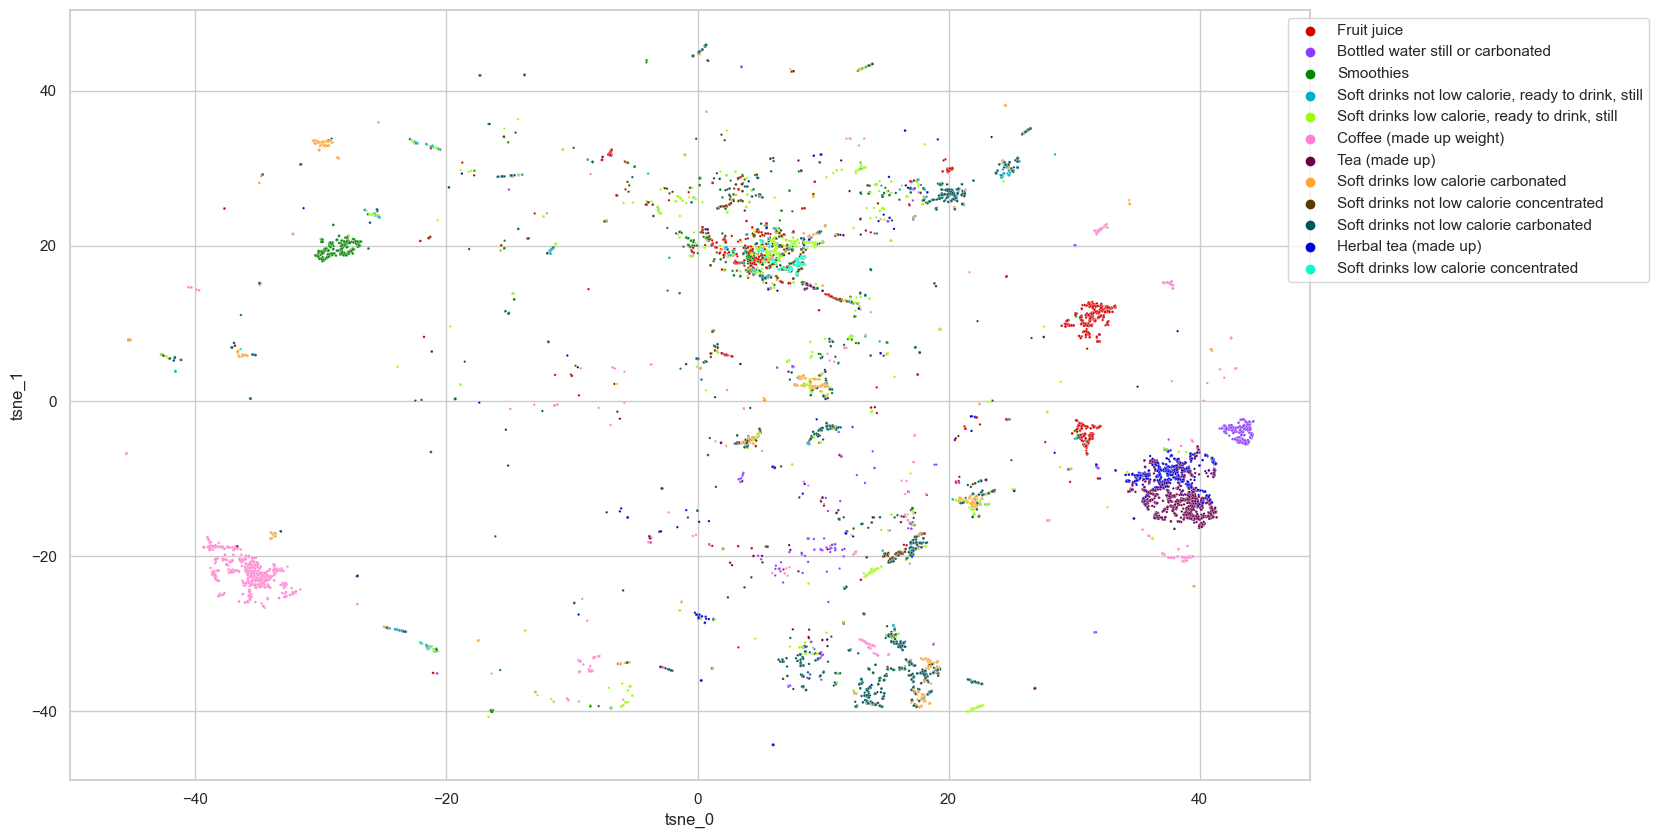

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [ ]:
# save level 2 cereal categories
pred.to_csv('../../SFS/NDNS UK/predictions/predictions_bev_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)